<a href="https://colab.research.google.com/github/coderacheal/Sunday/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

  - A multi-class classification problem that trains a pretrained bert model the sentiment of a message
  - Model will be embedded in a web app that will that uses web sockets for end to end communication over a network

## Install torch and transfromers

In [4]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
%pip install transformers

Looking in indexes: https://download.pytorch.org/whl/cu117
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 680.5 kB/s eta 0:00:00
ERROR: Operation cancelled by user


## Import all dependencies to be used for the project

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Mount drive to access the data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

df =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
...,...,...,...
937849,@Juice_Lemons in the dark. it’s so good,en,positive
937850,8.SSR &amp; Disha Salian case should be solved...,en,negative
937851,*ACCIDENT: Damage Only* - Raleigh Fire Depart...,en,negative
937852,@reblavoie So happy for her! She’s been incred...,en,positive


In [7]:
# df.shape

In [8]:
# df['Language'].unique()

In [9]:
# english_df = df[df['Language'] =='en']

# #let's drop the language column
# english_df.drop(columns='Language', inplace=True)


In [10]:
# uncertainty_df = english_df[df['Label'] =='uncertainty'][:30000]
# positive_df = english_df[df['Label'] =='positive'][:30000]
# negative_df = english_df[df['Label'] =='negative'][:30000]
# litigious_df = english_df[df['Label'] =='litigious'][:1200]

In [11]:
# uncertainty_df

In [12]:
# uncertainty_df['Text'][7]

## Feature Engineering

 - Engineer the litigious label to make it more extensive

In [13]:
litigious_records = []

litigious_sentences = [
    'The plaintiff alleges that the defendant committed defamation by spreading false and damaging statements about their character.',
    'The company is facing a lawsuit for patent infringement due to their unauthorized use of a patented technology.',
    'The accused party is being sued for breach of contract, as they failed to fulfill their obligations as outlined in the signed agreement.',
    'I will bury this place in so much law suit that your grand children are going to need lawyers',
    'The plaintiff claims substantial damages resulting from the defendant\'s fraudulent activities, including misrepresentation of financial information.',
    'The employer is facing a legal battle over allegations of wrongful termination and violation of labor laws, as the employee argues they were fired without just cause.',
    'The plaintiff seeks compensation for the alleged negligence of the defendant, which resulted in personal injury and financial loss.',
    'The company filed a lawsuit against its former employee for alleged misappropriation of trade secrets, claiming significant damages.',
    'The court issued an injunction to prevent the defendant from further trademark violation and ordered them to cease all unauthorized use of the protected mark.',
    'The plaintiff accuses the defendant of libel and slander, claiming that the false statements made by the defendant harmed their personal and professional reputation.',
    'The dispute between the two parties arose from an alleged breach of fiduciary duty, with the plaintiff asserting that the defendant prioritized personal gain over their legal obligations.',
    'The neighbors filed a complaint against each other for alleged trespassing, seeking a restraining order to prevent further disputes.',
    'The landlord is facing a lawsuit from the tenant, claiming breach of contract due to the landlord\'s failure to address necessary repairs in a timely manner.',
    'A legal battle between former spouses ensued over child custody, with both parties accusing each other of parental alienation and seeking sole custody rights.',
    'The homeowners\' association sent a cease and desist letter to a resident for violating community guidelines by conducting business activities from their home.',
    'Siblings engaged in a dispute over their late parent\'s estate, resulting in a contentious probate case with allegations of undue influence and mismanagement of assets.',
    "The opposing party's deliberate interference has caused significant financial losses.",
    "The discovery process will uncover crucial evidence to support our position.",
    "Our attorney will demonstrate the defendant's gross negligence beyond any reasonable doubt.",
    "The opposing counsel's attempt to mislead the court will not go unchallenged.",
    "The breach of contract is evident from the defendant's failure to fulfill obligations.",
    "Our legal representation will seek appropriate damages for the harm suffered.",
    "The defendant's reckless actions warrant punitive measures to deter future misconduct.",
    "Our legal team will file an appeal to rectify the erroneous ruling.",
    "The plaintiff's rights have been violated, necessitating immediate legal action."
]

for i in range(2500):
  for sentence in litigious_sentences:
    text = sentence
    label = 'litigious'
    record = {'Text': text, 'Label': label}
    litigious_records.append(record)


litigious_df = pd.DataFrame(litigious_records)

litigious_df.head()

,Text,Label
0,The plaintiff alleges that the defendant commi...,litigious
1,The company is facing a lawsuit for patent inf...,litigious
2,The accused party is being sued for breach of ...,litigious
3,I will bury this place in so much law suit tha...,litigious
4,The plaintiff claims substantial damages resul...,litigious


In [14]:
litigious_df.shape

(62500, 2)

In [15]:
positive_records = []

positive_sentences = [
    "A ray of sunshine illuminated the room, filling it with warmth and joy.",
    "Laughter echoed through the air, spreading contagious happiness to all.",
    "Love blossomed like a vibrant garden, filling hearts with pure bliss.",
    "The melody danced in the air, lifting spirits and creating a symphony of happiness.",
    "Dreams soared high like colorful kites, painting the sky with endless possibilities.",
    "Kindness rippled through the community, creating a tapestry of compassion and support.",
    "Achievement unlocked! The feeling of success washed over, rewarding dedication and hard work.",
    "The vibrant colors of nature painted a picturesque scene, invoking awe and wonder.",
    "Friendship sparkled like a precious gem, bringing companionship and endless smiles.",
    "Hope ignited like a flame, lighting the path to a brighter tomorrow.",
    "The sweet taste of victory lingered, reminding us that perseverance pays off.",
    "Innovation flourished, sparking new ideas and shaping a brighter future.",
    "A gentle breeze whispered serenity, soothing weary souls with tranquility.",
    "Talent blossomed like a rare flower, captivating hearts with its beauty.",
    "The embrace of a loved one radiated warmth, reminding us of the power of connection.",
    "New beginnings unfolded, opening doors to endless opportunities and growth.",
    "The sound of applause filled the room, celebrating accomplishments and inspiring confidence.",
    "Courage bloomed in the face of adversity, showing strength and resilience.",
    "The radiant smiles illuminated the room, spreading contagious happiness.",
    "Joy overflowed like a bubbling fountain, filling hearts with uncontainable delight.",
    "The scent of freshly baked goods wafted through the air, invoking feelings of comfort and joy.",
    "Inspiration sparked like a flame, igniting creativity and passion within.",
    "The symphony of laughter echoed, creating a harmonious melody of happiness.",
    "The world shimmered with endless possibilities, inviting dreams to take flight.",
    "Kind words uplifted spirits, weaving a tapestry of positivity and encouragement.",
]


for i in range(2500):
  for sentence in positive_sentences:
    text = sentence
    label = 'positive'
    record = {'Text': text, 'Label': label}
    positive_records.append(record)


positive_df = pd.DataFrame(positive_records)

positive_df.head()

,Text,Label
0,"A ray of sunshine illuminated the room, fillin...",positive
1,"Laughter echoed through the air, spreading con...",positive
2,"Love blossomed like a vibrant garden, filling ...",positive
3,"The melody danced in the air, lifting spirits ...",positive
4,"Dreams soared high like colorful kites, painti...",positive


In [16]:
positive_df.shape

(62500, 2)

In [17]:
negative_records = []

negative_sentences = [
    "Everything fell apart, leaving nothing but ruins in its wake.",
    "The world seemed engulfed in darkness, with no hope in sight.",
    "My heart shattered into a million pieces, irreparable and broken.",
    "The relentless pain gnawed at my soul, consuming any flicker of joy.",
    "Loneliness gripped me tightly, suffocating any sense of connection.",
    "All efforts were in vain, leading to a bitter and disappointing outcome.",
    "Regret seeped into my being, poisoning every thought and action.",
    "The weight of despair pressed upon my shoulders, crushing any sense of optimism.",
    "Tears cascaded down my cheeks, a river of sorrow and anguish.",
    "Betrayal cut deep, leaving scars that would never truly heal.",
    "Fear took hold of me, paralyzing any chance of taking a leap of faith.",
    "The dreams I once cherished turned into ashes, fading into oblivion.",
    "Every step forward seemed to lead to a deeper abyss of despair.",
    "Failure consumed me, whispering words of self-doubt and worthlessness.",
    "Dark clouds loomed overhead, casting a shadow of gloom upon everything.",
    "Bitterness poisoned my heart, staining even the sweetest moments.",
    "The world became a cruel and unforgiving place, devoid of compassion.",
    "The shattered pieces of trust could never be reassembled.",
    "My spirit was shattered, leaving me numb and hollow inside.",
    "The echoes of pain reverberated through my existence, a constant reminder.",
    "Desperation gripped my soul, leaving me grasping for any glimmer of hope.",
    "Anguish clung to me like a heavy cloak, draining away any remnants of happiness.",
    "The walls closed in around me, suffocating any chance of escape.",
    "Grief consumed me, engulfing every fiber of my being.",
    "There was no solace to be found, only a never-ending abyss of sorrow."
]

for i in range(2500):
  for sentence in negative_sentences:
    text = sentence
    label = 'negative'
    record = {'Text': text, 'Label': label}
    negative_records.append(record)


negative_df = pd.DataFrame(negative_records)

negative_df.head()

,Text,Label
0,"Everything fell apart, leaving nothing but rui...",negative
1,"The world seemed engulfed in darkness, with no...",negative
2,"My heart shattered into a million pieces, irre...",negative
3,"The relentless pain gnawed at my soul, consumi...",negative
4,"Loneliness gripped me tightly, suffocating any...",negative


In [18]:
negative_df.shape

(62500, 2)

In [19]:
uncertainty_records = []

uncertainty_sentences = [
    "I'm not quite sure how things will turn out in the end.",
    "There seems to be a lot of unknowns in this situation.",
    "It's hard to say for certain what the future holds.",
    "I find myself grappling with doubt and uncertainty.",
    "There's a sense of ambiguity surrounding this decision.",
    "I'm not entirely confident in my ability to make the right choice.",
    "Uncertainty clouds my judgment, making it difficult to decide.",
    "The outcome is up in the air, leaving me feeling unsure.",
    "I can't say with absolute certainty what the best course of action is.",
    "There's a lingering sense of doubt that I can't shake off.",
    "It feels like I'm navigating through a fog of uncertainty.",
    "The answers to my questions remain elusive and uncertain.",
    "I'm caught in a state of indecision, unsure which path to take.",
    "There's a constant nagging of uncertainty at the back of my mind.",
    "I find myself second-guessing every step I take.",
    "It's a complex situation, leaving me uncertain about the right approach.",
    "I'm wavering between different possibilities, unable to commit.",
    "The future feels unpredictable, with no clear path forward.",
    "There are so many variables at play, making it hard to predict the outcome.",
    "I'm grappling with a sense of doubt and unease about what lies ahead.",
    "The situation is filled with ambiguity, leaving me feeling lost.",
    "I'm uncertain about the implications and consequences of my choices.",
    "The answers I seek remain elusive, leaving me in a state of uncertainty.",
    "I'm struggling to find clarity amidst a sea of uncertainties.",
    "It's a challenging decision to make, and I'm uncertain about the right path."
]


for i in range(2500):
  for sentence in uncertainty_sentences:
    text = sentence
    label = 'uncertainty'
    record = {'Text': text, 'Label': label}
    uncertainty_records.append(record)


uncertainty_df = pd.DataFrame(uncertainty_records)

uncertainty_df.head()

,Text,Label
0,I'm not quite sure how things will turn out in...,uncertainty
1,There seems to be a lot of unknowns in this si...,uncertainty
2,It's hard to say for certain what the future h...,uncertainty
3,I find myself grappling with doubt and uncerta...,uncertainty
4,There's a sense of ambiguity surrounding this ...,uncertainty


In [20]:
uncertainty_df.shape

(62500, 2)

In [21]:
data = pd.concat([litigious_df, uncertainty_df, positive_df, negative_df], axis=0, ignore_index=True)
data

,Text,Label
0,The plaintiff alleges that the defendant commi...,litigious
1,The company is facing a lawsuit for patent inf...,litigious
2,The accused party is being sued for breach of ...,litigious
3,I will bury this place in so much law suit tha...,litigious
4,The plaintiff claims substantial damages resul...,litigious
...,...,...
249995,"Desperation gripped my soul, leaving me graspi...",negative
249996,"Anguish clung to me like a heavy cloak, draini...",negative
249997,"The walls closed in around me, suffocating any...",negative
249998,"Grief consumed me, engulfing every fiber of my...",negative


## EDA

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    250000 non-null  object
 1   Label   250000 non-null  object
dtypes: object(2)
memory usage: 3.8+ MB


In [23]:
sentiments = data['Label'].value_counts().sort_values(ascending=False)
sentiments

Label
litigious      62500
uncertainty    62500
positive       62500
negative       62500
Name: count, dtype: int64

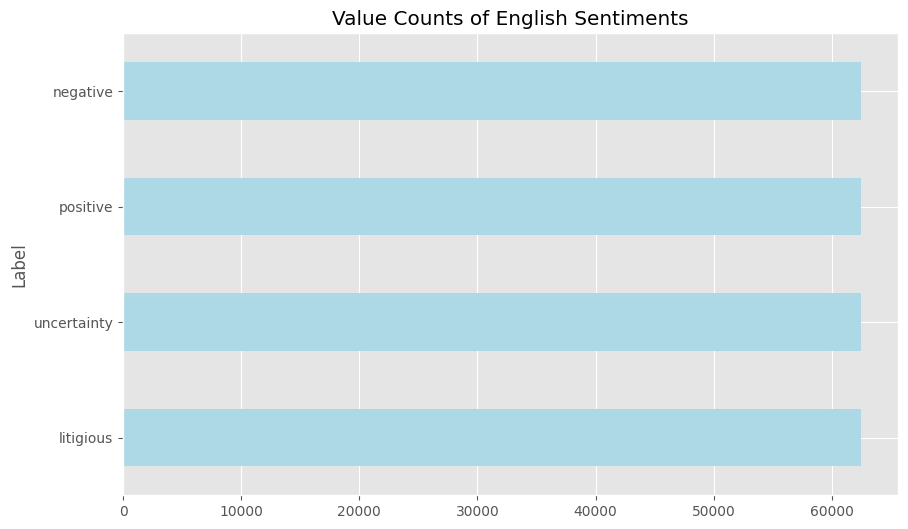

In [24]:
sentiments.plot(kind='barh', color='lightblue', figsize=(10,6))
plt.title('Value Counts of English Sentiments')
plt.show()

In [25]:
data = data.sample(frac=1, random_state=42)  # Frac=1 ensures all rows are included, random_state for reproducibility

data.head()


,Text,Label
38683,The court issued an injunction to prevent the ...,litigious
64939,I find myself second-guessing every step I take.,uncertainty
3954,The plaintiff claims substantial damages resul...,litigious
120374,"It's a challenging decision to make, and I'm u...",uncertainty
172861,"Innovation flourished, sparking new ideas and ...",positive


In [26]:
data.shape


(250000, 2)

# Let's Train a Bert Model with a quarter million Tweets

#### Creating Tokenizer and Model

Let's convert our text and label column into list for easy splitting



In [27]:
X = data['Text'].to_list()
y = data['Label'].to_list()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(y_train)

In [28]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the training texts
train_encodings = tokenizer(X_train, truncation=True, padding=True)
train_labels = torch.tensor(train_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [29]:
# Tokenize and encode the test texts
test_encodings = tokenizer(X_test, truncation=True, padding=True)
test_labels = torch.tensor(label_encoder.transform(y_test))

In [30]:
# Create train and test datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [31]:

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [32]:
#Create train and test dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [33]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [35]:
# Set training parameters
num_epochs = 1
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
#Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

In [ ]:
# evaluate perfomance of model
model.eval()

# Initialize lists for storing true labels and predicted labels
true_labels = []
predicted_labels = []

# Initialize list for storing predicted probabilities
predicted_probs = []

# Iterate over the test dataset in an evaluation loop
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_classes = logits.argmax(dim=1)
        probabilities = torch.softmax(logits, dim=1)

        # Store true labels and predicted labels
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted_classes.tolist())

        # Store predicted probabilities
        predicted_probs.extend(probabilities.tolist())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


In [ ]:
# Input text for prediction
input_text = "The relentless storm unleashed its fury, causing widespread destruction and leaving behind a scene of utter devastation"

# Tokenize and encode the input text
input_encoding = tokenizer(input_text, truncation=True, padding=True, return_tensors='pt')

# Make predictions
model.eval()
with torch.no_grad():
    input_ids = input_encoding['input_ids'].to(device)
    attention_mask = input_encoding['attention_mask'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_labels = logits.argmax(dim=1)

# Convert predicted labels back to original classes using label_encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels.cpu().numpy())

# Print the predicted class
print("Predicted class:", predicted_classes[0])


### Persist Model

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/my_model')